In [1]:
!nvidia-smi

Tue Sep 13 12:24:45 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   61C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## 1) Installing libraries

In [2]:
!pip install transformers
!pip install datasets
!pip install wandb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from datasets import load_dataset, Dataset

## 2) Loading dataset (from HF)


In [4]:
# enter your personal read token

In [5]:
from huggingface_hub import notebook_login
notebook_login()

Login successful
Your token has been saved to /root/.huggingface/token
Authenticated through git-credential store but this isn't the helper defined on your machine.
You might have to re-authenticate when pushing to the Hugging Face Hub. Run the following command in your terminal in case you want to set this credential helper as the default

git config --global credential.helper store


In [6]:
from datasets import load_dataset

aggression_dataset = load_dataset("IIIT-L/total_code_mixed", use_auth_token=True)

print(aggression_dataset)

  0%|          | 0/3 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['Sentence', 'Label'],
        num_rows: 3976
    })
    test: Dataset({
        features: ['Sentence', 'Label'],
        num_rows: 498
    })
    validation: Dataset({
        features: ['Sentence', 'Label'],
        num_rows: 497
    })
})


In [7]:
train_ds = aggression_dataset['train']
train_ds

Dataset({
    features: ['Sentence', 'Label'],
    num_rows: 3976
})

## 3) Converting to dataframe

In [8]:
aggression_dataset.set_format(type='pandas')
train_df = aggression_dataset['train'][:]
valid_df = aggression_dataset['validation'][:]

train_df.head()

,Sentence,Label
0,We don't spend one hour and rush off from our ...,1
1,Shivani my classmate,0
2,True reviewerÃƒÂ°Ã…Â¸Ã¢â€žÂ¢Ã‚Â,0
3,Royal C***yas Bangalore ÃƒÂ°Ã…Â¸Ã‹Å“Ã¢â‚¬Å¡ÃƒÂ...,2
4,*PURE DESH ME AFRA TAFRI KA MAHOOL HAI...INDIA...,2


In [9]:
test_df = aggression_dataset['test'][:]

In [10]:
train_df['Label'].value_counts()

0    2137
1    1086
2     753
Name: Label, dtype: int64

In [11]:
# 3976
# NAG-CAG-OAG (0-1-2) = 0.54-0.27-0.19

Seeing Distribution

In [12]:
disb_df = train_df.copy(deep=True)

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


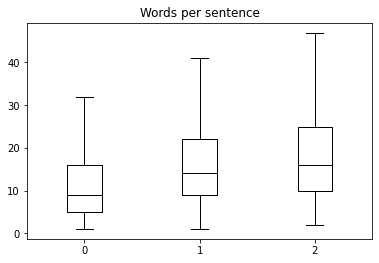

In [13]:
disb_df['Words per sentence'] = disb_df['Sentence'].str.split().apply(len)
disb_df.boxplot('Words per sentence', by='Label', grid=False, showfliers=False, color='black')
plt.suptitle("")
plt.xlabel("")
plt.show()

## 4) Tokenizing

In [14]:
from transformers import AutoTokenizer

In [15]:
model_ckpt = 'roberta-base'
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

In [16]:
tokenizer.vocab_size

50265

In [17]:
train_texts = list(train_df['Sentence'])
train_labels = list(train_df['Label'])

In [18]:
valid_texts = list(valid_df['Sentence'])
valid_labels = list(valid_df['Label'])

## 5) Encoding train-valid

In [19]:
train_encodings = tokenizer(train_texts, truncation=True, padding=True)
valid_encodings = tokenizer(valid_texts, truncation=True, padding=True)

In [20]:
import torch

class AggressionDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

In [21]:
train_dataset = AggressionDataset(train_encodings, train_labels)
valid_dataset = AggressionDataset(valid_encodings, valid_labels)

## 6) Setting classification model and evaluation metrics

In [22]:
import torch

In [23]:
# Use in case of CUDA memory error

# import gc

# gc.collect()
# torch.cuda.empty_cache()

In [24]:
from transformers import AutoModelForSequenceClassification

num_labels = 3
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

def model_init():
    model = (AutoModelForSequenceClassification.from_pretrained(model_ckpt, num_labels=num_labels))
    return model

cuda


In [25]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, plot_confusion_matrix

def compute_metrics(pred):
  labels = pred.label_ids
  preds = pred.predictions.argmax(-1)

  f1 = f1_score(labels, preds, average='macro')
  precision = precision_score(labels, preds, average='macro')
  recall = recall_score(labels, preds, average='macro')
  acc = accuracy_score(labels, preds)
  return {'accuracy': acc, 'precision': precision, 'recall': recall, 'f1': f1}

## 7) Fine-tuning, visualizing training, saving model to HF  

In [26]:
import wandb

wandb.login()

ERROR:wandb.jupyter:Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: dnyaneshwar-bhadane. Use `wandb login --relogin` to force relogin


True

In [27]:
%env WANDB_PROJECT = aggression_detection

env: WANDB_PROJECT=aggression_detection


In [28]:
from transformers import Trainer, TrainingArguments

In [29]:
# Defining hyperparameters
eval_batch_size = 16
logging_steps = len(train_texts) // eval_batch_size
model_name = f"{model_ckpt}-finetuned-code-mixed-DS"
training_args = TrainingArguments(output_dir=model_name,
                                  num_train_epochs=6,
                                  learning_rate=4.1187640010910775e-05,
                                  per_device_train_batch_size=8,
                                  per_device_eval_batch_size=16,
                                  weight_decay=0.13668695797323277,
                                  evaluation_strategy='steps',
                                  save_strategy='steps',
                                  max_steps=-1,
                                  warmup_ratio=0.0,
                                  seed=43,
                                  data_seed=4,
                                  metric_for_best_model="eval_f1",
                                  greater_is_better=True,
                                  load_best_model_at_end=True, 
                                  disable_tqdm=False,
                                  logging_steps=logging_steps,
                                  save_steps=logging_steps,
                                  log_level='info', 
                                  report_to="wandb", 
                                  run_name="roberta-code-mixed-DS",
                                  push_to_hub=True)

In [30]:
# import gc

# gc.collect()
# torch.cuda.empty_cache()

In [31]:
from torch import nn

class CustomTrainer(Trainer):
  def compute_loss(self, model, inputs, return_outputs=False):
    device = torch.device('cuda')
    inputs.to(device)
    labels = inputs.get("labels")
    # forward pass
    outputs = model(**inputs)
    logits = outputs.get("logits")
    # compute custom loss (suppose one has 3 labels with different weights)
    loss_fct = nn.CrossEntropyLoss(weight=torch.tensor([0.17, 0.27, 0.56]).to(device))
    loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))
    return (loss, outputs) if return_outputs else loss

In [32]:
from transformers import EarlyStoppingCallback

In [34]:
# enter your personal write token here

from huggingface_hub import notebook_login
notebook_login()

In [35]:
trainer = CustomTrainer(model_init=model_init,
                        args=training_args,
                        compute_metrics = compute_metrics,
                        train_dataset = train_dataset,
                        eval_dataset = valid_dataset,
                        tokenizer = tokenizer 
                        # callbacks = [EarlyStoppingCallback(early_stopping_patience = 2, early_stopping_threshold=0.0001)]
)

trainer.train()

# post-training analysis, testing, other logged code
wandb.finish()

loading configuration file https://huggingface.co/roberta-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/733bade19e5f0ce98e6531021dd5180994bb2f7b8bd7e80c7968805834ba351e.35205c6cfc956461d8515139f0f8dd5d207a2f336c0c3a83b4bc8dca3518e37b
Model config RobertaConfig {
  "_name_or_path": "roberta-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2
  },
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transfo

Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
248,1.049900,1.121125,0.587525,0.378101,0.532273,0.423527
496,1.026300,0.958438,0.537223,0.364586,0.489574,0.390825
744,0.997900,0.912292,0.513078,0.384416,0.504463,0.387056
992,0.971900,0.896372,0.513078,0.405516,0.518248,0.392121
1240,0.843600,0.839068,0.611670,0.541501,0.557842,0.516403
1488,0.845000,0.881908,0.655936,0.568165,0.564802,0.565174
1736,0.763900,0.905339,0.682093,0.606645,0.610686,0.607842
1984,0.737500,0.817784,0.702213,0.631903,0.613637,0.616893
2232,0.652400,0.775016,0.702213,0.662385,0.618211,0.609415
2480,0.635000,0.874349,0.688129,0.625552,0.629850,0.626616


***** Running Evaluation *****
  Num examples = 497
  Batch size = 16
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Saving model checkpoint to roberta-base-finetuned-code-mixed-DS/checkpoint-248
Configuration saved in roberta-base-finetuned-code-mixed-DS/checkpoint-248/config.json
Model weights saved in roberta-base-finetuned-code-mixed-DS/checkpoint-248/pytorch_model.bin
tokenizer config file saved in roberta-base-finetuned-code-mixed-DS/checkpoint-248/tokenizer_config.json
Special tokens file saved in roberta-base-finetuned-code-mixed-DS/checkpoint-248/special_tokens_map.json
tokenizer config file saved in roberta-base-finetuned-code-mixed-DS/tokenizer_config.json
Special tokens file saved in roberta-base-finetuned-code-mixed-DS/special

eval/accuracy,▄▂▁▁▅▆▇██▇██
eval/f1,▂▁▁▁▄▆▇▇▇▇▇█
eval/loss,█▅▄▃▂▃▄▂▁▃▆▅
eval/precision,▁▁▁▂▅▆▇▇█▇▇█
eval/recall,▃▁▂▂▄▄▆▆▇▇▇█
eval/runtime,▇█▆▅▂▃▂▁▁▆▇▁
eval/samples_per_second,▂▁▃▄▇▆▇██▃▂█
eval/steps_per_second,▂▁▄▅▇▇███▃▃█
train/epoch,▁▁▂▂▂▂▃▃▄▄▄▄▅▅▅▅▆▆▇▇▇▇███
train/global_step,▁▁▂▂▂▂▃▃▄▄▄▄▅▅▅▅▆▆▇▇▇▇███
train/learning_rate,█▇▇▆▅▅▄▄▃▂▂▁


In [36]:
trainer.push_to_hub()

Saving model checkpoint to roberta-base-finetuned-code-mixed-DS
Configuration saved in roberta-base-finetuned-code-mixed-DS/config.json
Model weights saved in roberta-base-finetuned-code-mixed-DS/pytorch_model.bin
tokenizer config file saved in roberta-base-finetuned-code-mixed-DS/tokenizer_config.json
Special tokens file saved in roberta-base-finetuned-code-mixed-DS/special_tokens_map.json
Several commits (5) will be pushed upstream.
The progress bars may be unreliable.


Upload file pytorch_model.bin:   0%|          | 3.34k/476M [00:00<?, ?B/s]

remote: Scanning LFS files for validity, may be slow...        
remote: LFS file scan complete.        
To https://huggingface.co/Dnyaneshwar/roberta-base-finetuned-code-mixed-DS
   b926583..34cfbec  main -> main

remote: LFS file scan complete.        
To https://huggingface.co/Dnyaneshwar/roberta-base-finetuned-code-mixed-DS
   b926583..34cfbec  main -> main

Dropping the following result as it does not have all the necessary fields:
{'task': {'name': 'Text Classification', 'type': 'text-classification'}, 'metrics': [{'name': 'Accuracy', 'type': 'accuracy', 'value': 0.7082494969818913}, {'name': 'Precision', 'type': 'precision', 'value': 0.6550028040156031}, {'name': 'Recall', 'type': 'recall', 'value': 0.6487764043381318}, {'name': 'F1', 'type': 'f1', 'value': 0.647931898322507}]}
To https://huggingface.co/Dnyaneshwar/roberta-base-finetuned-code-mixed-DS
   34cfbec..c0f467a  main -> main

   34cfbec..c0f467a  main -> main



'https://huggingface.co/Dnyaneshwar/roberta-base-finetuned-code-mixed-DS/commit/34cfbec08d09a3b64b07201688407825e214c6d8'

## 8) Predictions and Results

In [37]:
test_texts = list(test_df['Sentence'])
test_labels = list(test_df['Label'])

In [38]:
test_encodings = tokenizer(test_texts, truncation=True, padding=True)

In [39]:
test_dataset = AggressionDataset(test_encodings, test_labels)

In [40]:
preds_output_test = trainer.predict(test_dataset)

***** Running Prediction *****
  Num examples = 498
  Batch size = 16


In [41]:
preds_output_test.metrics

{'test_loss': 0.9071078300476074,
 'test_accuracy': 0.7188755020080321,
 'test_precision': 0.6562444554570539,
 'test_recall': 0.6547752476665484,
 'test_f1': 0.6542265271599236,
 'test_runtime': 15.2848,
 'test_samples_per_second': 32.581,
 'test_steps_per_second': 2.094}

In [42]:
y_preds_test = np.argmax(preds_output_test.predictions, axis=1)

In [43]:
y_valid_test = np.array(test_dataset.labels)

In [44]:
map_dt = {0:'NAG', 1:'CAG', 2:'OAG'}

In [45]:
print(classification_report(y_valid_test, y_preds_test, target_names=list(map_dt.values())))

              precision    recall  f1-score   support

         NAG       0.90      0.85      0.87       268
         CAG       0.53      0.60      0.56       136
         OAG       0.55      0.51      0.53        94

    accuracy                           0.72       498
   macro avg       0.66      0.65      0.65       498
weighted avg       0.73      0.72      0.72       498



In [46]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

y_valid_trying = map(lambda x : map_dt[x], y_valid_test)
y_valid_trying = list(y_valid_trying)

y_preds_trying = map(lambda x : map_dt[x], y_preds_test)
y_preds_trying = list(y_preds_trying)

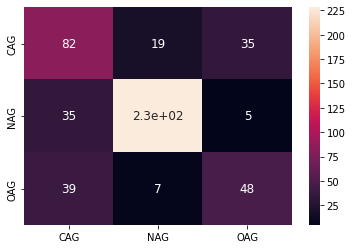

In [47]:
cm_labels = np.unique(y_valid_trying)
cm_array = confusion_matrix(y_valid_trying, y_preds_trying)
cm_array_df = pd.DataFrame(cm_array, index=cm_labels, columns=cm_labels)
sns.heatmap(cm_array_df, annot=True, annot_kws={"size": 12}) 